In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, warn_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False,warn_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, warn_bad_lines=False ,encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

C:\Users\hp\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hp\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\hp\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\hp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


In [3]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [4]:
print(users.shape)
print(list(users.columns))

(278814, 3)
['userID', 'Location', 'Age']


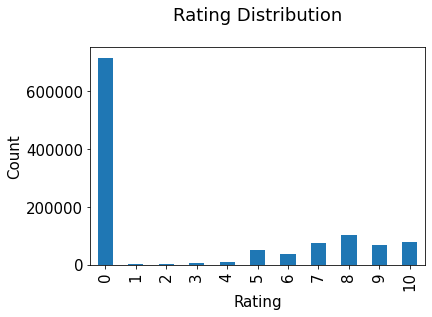

In [5]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
#plt.savefig('system1.png', bbox_inches='tight')
plt.show()

# Collaborative Filtering Using k-Nearest Neighbors (kNN)
kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user,

In [6]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


We then group by book titles and create a new column for total rating count.

In [7]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [8]:
combine_book_rating.shape

(1031136, 4)

In [9]:
book_ratingCount.shape

(241071, 2)

We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [10]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   241071.000
mean         4.277
std         16.739
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: totalRatingCount, dtype: float64


The median book has been rated only once. Let’s look at the top of the distribution

In [13]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,60
1,2313,034545104X,5,Flesh Tones: A Novel,60
2,6543,034545104X,0,Flesh Tones: A Novel,60
3,8680,034545104X,5,Flesh Tones: A Novel,60
4,10314,034545104X,9,Flesh Tones: A Novel,60


In [14]:
rating_popular_book.shape

(403993, 5)

## Implementing kNN
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.



In [15]:
from scipy.sparse import csr_matrix
rating_popular_book = rating_popular_book.drop_duplicates(['userID', 'bookTitle'])
#ratings and user matrix in pivot
rating_popular_book_pivot = rating_popular_book.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
rating_popular_book_matrix = csr_matrix(rating_popular_book_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_popular_book_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [16]:
query_index = np.random.choice(rating_popular_book_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(rating_popular_book_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

4612


In [17]:
rating_popular_book_pivot.index[query_index]

'The House on Hope Street'

In [18]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_popular_book_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, rating_popular_book_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The House on Hope Street:

1: Passion's Promise, with distance of 0.8203327435122326:
2: Star, with distance of 0.835059023669067:
3: Malice, with distance of 0.8385892715242771:
4: Special Delivery, with distance of 0.8471623429529145:
5: The Cat Who Went Underground, with distance of 0.8511420021659257:


In [19]:
res=[]
for i in range(0,2444):
    res.append(rating_popular_book_pivot.index[i])
res

["'Salem's Lot",
 '10 Lb. Penalty',
 '101 Dalmatians',
 '14,000 Things to Be Happy About',
 '16 Lighthouse Road',
 '1984',
 '1st to Die: A Novel',
 '2001: A Space Odyssey',
 '2010: Odyssey Two',
 '204 Rosewood Lane',
 '2061: Odyssey Three',
 '24 Hours',
 '253',
 '2nd Chance',
 '3001: The Final Odyssey',
 '311 Pelican Court',
 '3rd Degree',
 '4 Blondes',
 '50 Simple Things You Can Do to Save the Earth',
 '52 Deck Series: 52 Ways to Celebrate Friendship',
 '7b',
 '8 Weeks to Optimum Health',
 '8.4',
 '84 Charing Cross Road',
 '9-11',
 'A 2nd Helping of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))',
 'A 3rd Serving of Chicken Soup for the Soul (Chicken Soup for the Soul Series (Paper))',
 'A 4th Course of Chicken Soup for the Soul: 101 More Stories to Open the Heart and Rekindle the Spirit',
 'A 5th Portion of Chicken Soup for the Soul : 101 Stories to Open the Heart and Rekindle the Spirit',
 'A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate Jo

In [20]:
len(res)

5854

In [21]:
lst=[]
for i in res:
    ind=books[books['bookTitle']==i].index[0]
    lst.append([books.loc[ind,'ISBN'],books.loc[ind,'bookTitle'],books.loc[ind,'bookAuthor'],books.loc[ind,'imageUrlL']])
df2 = pd.DataFrame(lst,columns=['ISBN','title','author','image_url'])
df2.head()

,ISBN,title,author,image_url
0,0451168089,'Salem's Lot,Stephen King,http://images.amazon.com/images/P/0451168089.0...
1,0399143025,10 Lb. Penalty,Dick Francis,http://images.amazon.com/images/P/0399143025.0...
2,0307001164,101 Dalmatians,Justine Korman,http://images.amazon.com/images/P/0307001164.0...
3,0894803700,"14,000 Things to Be Happy About",Barbara Ann Kipfer,http://images.amazon.com/images/P/0894803700.0...
4,1551668300,16 Lighthouse Road,Debbie Macomber,http://images.amazon.com/images/P/1551668300.0...


In [22]:
df2.shape

(5854, 4)

In [23]:
import pickle
saved_model = pickle.dumps(model_knn)

In [24]:
models_list = [saved_model , res , rating_popular_book_pivot , df2]
with open('collab.pkl', 'wb') as f:
    pickle.dump(models_list, f)